# Wine Classification: Logistic Regression and SVM
## Peter Wallace

### Loading the data

In [1]:
from sklearn import datasets
import numpy as np

wine = datasets.load_wine()
#using all features
X = wine.data[:, [0,1,2, 3, 4 ,5, 6, 7, 8 , 9, 10 ,11, 12]]
#class labels
y = wine.target
#print unique class labels as integers
print('Class labels:', np.unique(y))

Class labels: [0 1 2]


### 25/75 Test Train Split

In [4]:
from sklearn.model_selection import train_test_split

#split 75% training, 35% testing; stratify ensures that you
#have the same proportions of classes within the two sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1, stratify=y)

In [5]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [59 71 48]
Labels counts in y_train: [44 53 36]
Labels counts in y_test: [15 18 12]


### Standardizing features

In [6]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
#estimate the sample mean and stdev
sc.fit(X_train)
#standardizing training and test set
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

### Logistic regression class definition 

In [7]:
class LogisticRegressionGD(object):
    """Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
      
    cost_ : list
      Sum-of-squares cost function value in each epoch.

    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            # note that we compute the logistic `cost` now
            # instead of the sum of squared errors cost
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # equivalent to:
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

### Establishing logistic regression model

In [8]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

lr = LogisticRegression(C=100.0, random_state=1)
lr.fit(X_train_std, y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Determining test vs. train accuracy

In [10]:

#applying trained set to test set
y_pred = lr.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())

Misclassified samples: 2


In [11]:
from sklearn.metrics import accuracy_score

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 0.96


### Establishing SVM model

In [12]:
from sklearn import svm

svmModel = svm.SVC(C=100.0, random_state=1)
svmModel.fit(X_train_std, y_train)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)

### Plotting weights against various C values (logistic regression)

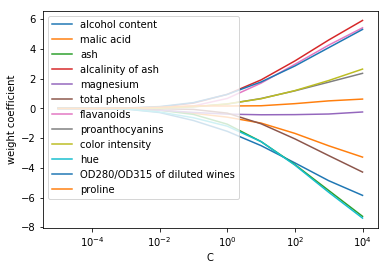

In [13]:
weights, params = [], []
# c is inverse of lambda tuning parameter
for c in np.arange(-5, 5):
    # fit 10 different models with diffent C values
    lr = LogisticRegression(C=10.**c, random_state=1)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1]) #save weights
    params.append(10.**c) #save parameters

attributeNames = ["alcohol content", "malic acid", "ash", "alcalinity of ash", 
         "magnesium", "total phenols", "flavanoids", "proanthocyanins",
        "color intensity", "hue", "OD280/OD315 of diluted wines", "proline"]

weights = np.array(weights)
for x in range(0,12):
    labelName = attributeNames[x]
    plt.plot(params, weights[:, x],
             label=labelName)
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()

### Calculating & plotting test error against various C values (logistic regression)

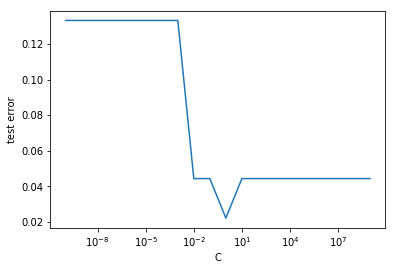

In [16]:

error, params = [], []
# c is inverse of lambda tuning parameter
for c in np.arange(-10, 10):
    # fit 10 different models with diffent C values
    lr = LogisticRegression(C=10.**c, random_state=1)
    lr.fit(X_train_std, y_train)
    #list of predicted test values
    pred_list = lr.predict(X_test_std)
    sum = 0
    #iterate over number of all samples in test set
    for x in range(0, np.sum(np.bincount(y_test))):
        y_pred = pred_list[x]
        y_actual= y_test[x]
        #difference of actual - predicted for each sample in test set
        dif = y_actual - y_pred
        dif_sq = dif**2
        sum = sum + dif_sq
    #te = sum all sq. error / number of samples in test set
    te = sum/np.sum(np.bincount(y_test))
    #append to array
    error.append(te) 
    params.append(10.**c)

error = np.array(error)
plt.plot(params, error)
plt.ylabel('test error')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()


### Calculating & plotting test error against various C values (SVM)

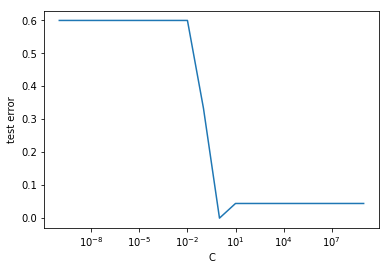

In [17]:

error, params = [], []
# c is inverse of lambda tuning parameter
for c in np.arange(-10, 10):
    # fit 10 different models with diffent C values
    svmModel = svm.SVC(C=10.**c, random_state=1, gamma=.01)
    svmModel.fit(X_train_std, y_train)
    #list of predicted test values
    pred_list = svmModel.predict(X_test_std)
    sum = 0
    #iterate over number of all samples in test set
    for x in range(0, np.sum(np.bincount(y_test))):
        y_pred = pred_list[x]
        y_actual= y_test[x]
        #difference of actual - predicted for each sample in test set
        dif = y_actual - y_pred
        dif_sq = dif**2
        sum = sum + dif_sq
    #te = sum all sq. error / number of samples in test set
    te = sum/np.sum(np.bincount(y_test))
    #append to array
    error.append(te) 
    params.append(10.**c)

error = np.array(error)
plt.plot(params, error)
plt.ylabel('test error')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()